In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import seed
seed(1337)
import tensorflow
tensorflow.random.set_seed(42)

# DATA

In [2]:
train_data_dir = "sample/train"
test_data_dir = "sample/test"
val_data_dir = "sample/validation"
category_names = sorted(os.listdir('sample/train'))
nb_categories = len(category_names)
img_pr_cat = []

Text(0.5, 1.0, 'Number of training images per category:')

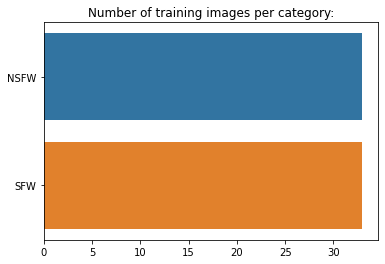

In [3]:
for category in category_names:
    folder = 'sample/train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

Text(0.5, 1.0, 'Number of test images per category:')

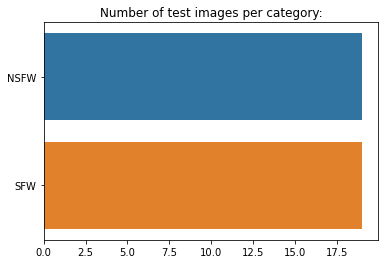

In [4]:
category_names = sorted(os.listdir('sample/test'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = 'sample/test' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of test images per category:")

# image quality

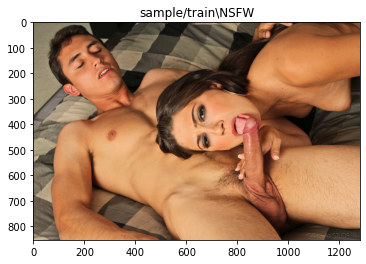

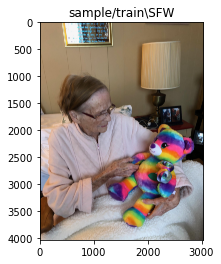

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
for subdir, dirs, files in os.walk('sample/train'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

# Pre-Processing 

In [6]:
img_height, img_width = 224,224

In [7]:
#Number of images to load at each iteration
batch_size = 5


#  rescaling
train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)



# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

print('Total number of images for "test":')
val_generator = val_datagen.flow_from_directory(
val_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

print('Total number of images for "test":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 66 images belonging to 2 classes.
Total number of images for "test":
Found 38 images belonging to 2 classes.
Total number of images for "test":
Found 38 images belonging to 2 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers 
from tensorflow.keras.optimizers import Adam

# downloading VGG pretrained model

In [9]:
vgg16_model =  vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

In [10]:
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

# ADDING LAYERS TO PRETRAINED MODEL 

In [11]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D,Dropout
# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg16_model)

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


## add our new output layer, consisting of only 2 nodes that correspond to NSFW and SFW. This output layer will be the only trainable layer in the model.

In [12]:
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_categories, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 15,242,050
Trainable params: 15,242,050
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
checkpoint = ModelCheckpoint("classifier.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)

In [15]:
#Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=
         train_generator.samples/train_generator.batch_size,
      epochs=5,
      validation_data=val_generator, 
      validation_steps=
         val_generator.samples/val_generator.batch_size,
      verbose=1,
callbacks=[checkpoint])

Train for 13.2 steps, validate for 7.6 steps
Epoch 1/5
14/13 [===============================] - 18s 1s/step - loss: 0.8630 - accuracy: 0.4848 - val_loss: 0.7820 - val_accuracy: 0.5000
Epoch 2/5
14/13 [===============================] - 8s 557ms/step - loss: 0.8613 - accuracy: 0.5606 - val_loss: 0.7463 - val_accuracy: 0.4737
Epoch 3/5
14/13 [===============================] - 8s 570ms/step - loss: 0.7558 - accuracy: 0.4242 - val_loss: 0.7487 - val_accuracy: 0.5000
Epoch 4/5
14/13 [===============================] - 8s 555ms/step - loss: 0.6897 - accuracy: 0.5000 - val_loss: 0.7167 - val_accuracy: 0.5000
Epoch 5/5
14/13 [===============================] - 8s 556ms/step - loss: 0.6734 - accuracy: 0.7121 - val_loss: 0.7459 - val_accuracy: 0.5789


# PLOTTING OF MODEL RESULTS

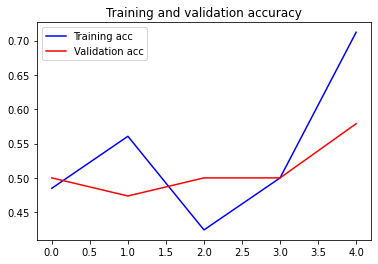

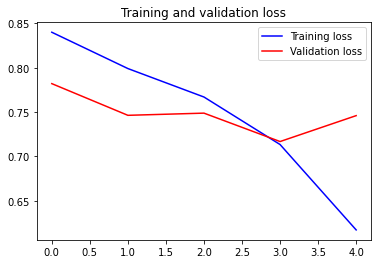

In [16]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(history)

# visualization of the errors

In [17]:
# Utility function for obtaining of the errors 
def obtain_errors(val_generator, predictions):
    # Get the filenames from the generator
    fnames = test_generator.filenames

    # Get the ground truth from generator
    ground_truth = test_generator.classes

    # Get the dictionary of classes
    label2index = test_generator.class_indices

    # Obtain the list of the classes
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)

    # Get the class index
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),test_generator.samples))
    
    return idx2label, errors, fnames


In [18]:
# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames):
    # Show the errors
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(test_data_dir,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

8/7 [===============================] - 2s 277ms/step
The list of classes:  ['NSFW', 'SFW']
Number of errors = 16/38


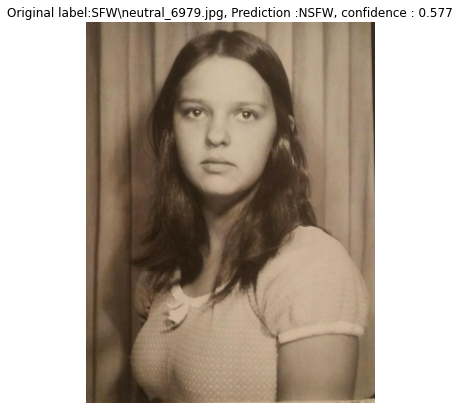

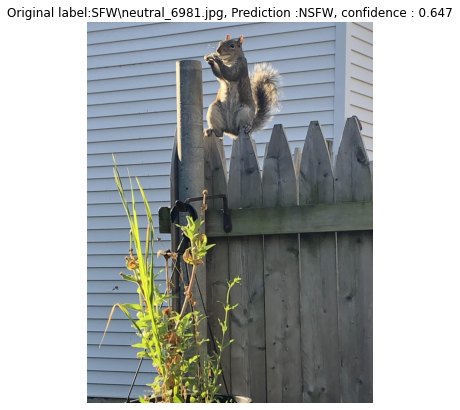

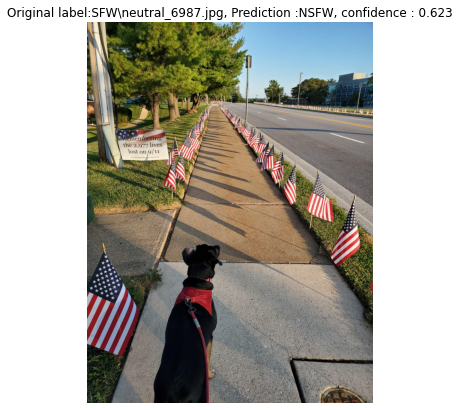

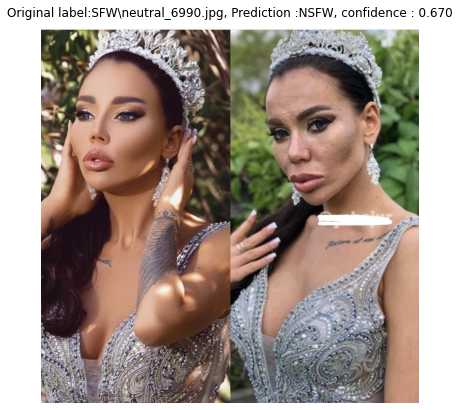

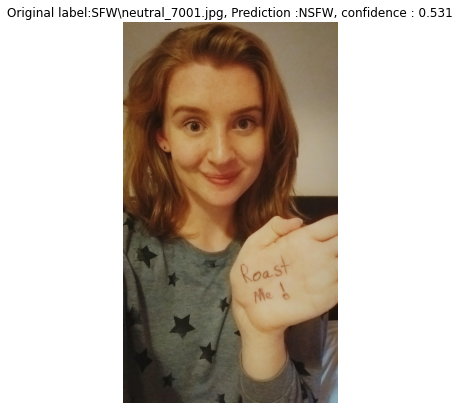

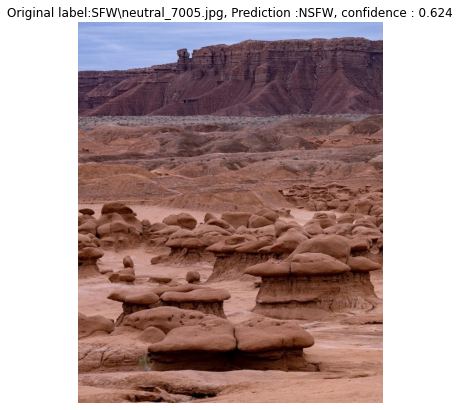

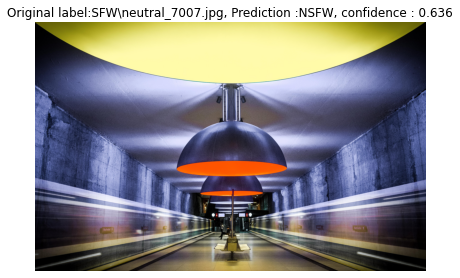

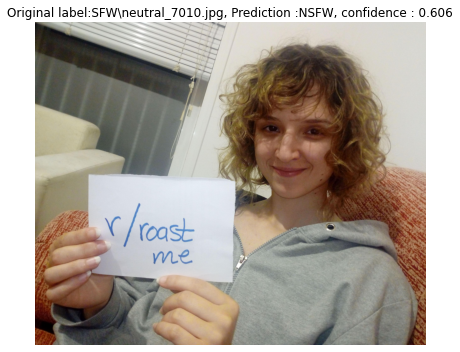

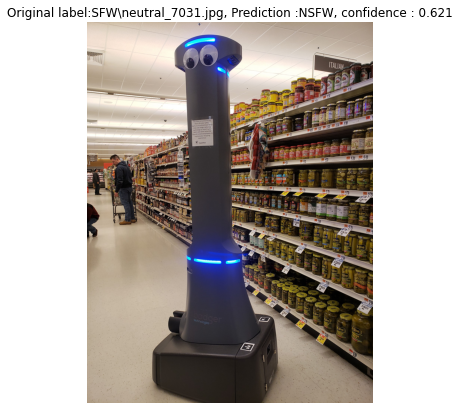

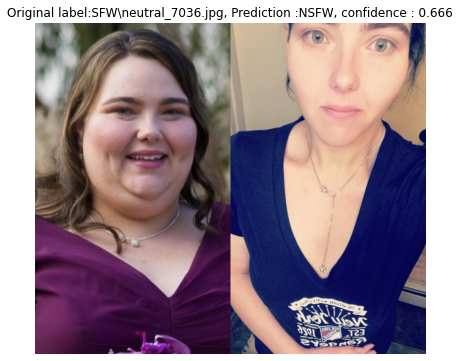

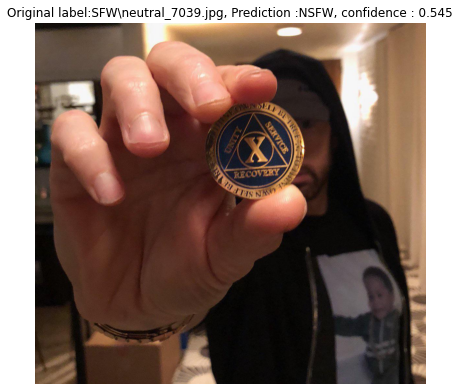

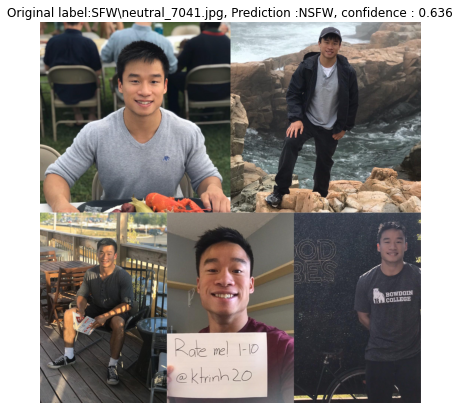

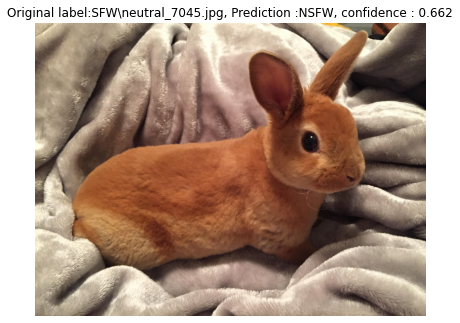

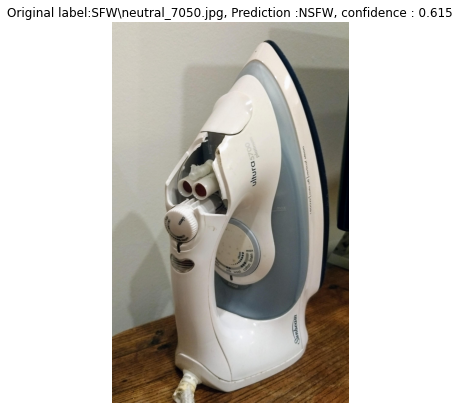

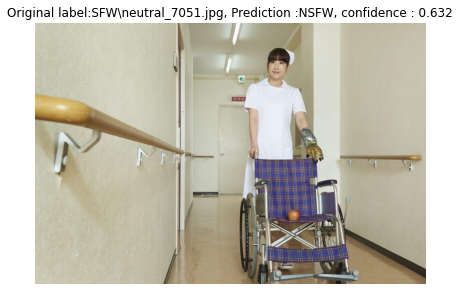

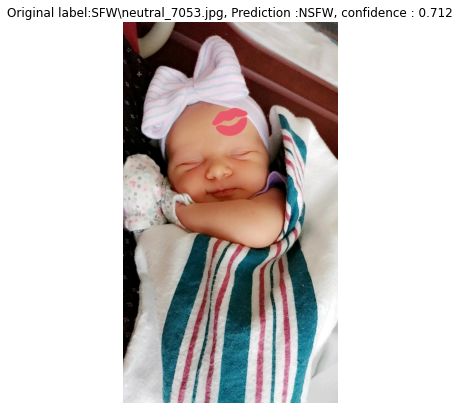

In [19]:
# Get the predictions from the model using the generator
predictions = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(test_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames)

## Evaluate on validation set


# PLOT CONFUSION MATRIX 

In [ ]:
# EVAL
test_gen = test_datagen.flow(val_generator, batch_size=10, shuffle=False)
probabilities = model.predict_generator(test_gen)

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(yv, axis=1), np.argmax(probabilities,axis=1))
_ = print_confusion_matrix(cnf_matrix, selected_breed_list)

In [ ]:
# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_breed_list)
print(report)

# TESTING ON IMAGES BY URL

In [ ]:
# Testing on url images
from libraries.data_iterators.support import deal_with_accents
from support import prediction_from_url
from ipywidgets import interact_manual
from ipywidgets import widgets

def get_prediction(URL):
    prediction_from_url(URL, model, selected_breed_list)

interact_manual(get_prediction, URL=widgets.Text(placeholder='https://picsum.photos/id/237/200/300'));

# SAVE THE MODEL

In [ ]:
# Saving Model Weight
model.save_weights('models/tl_VGG_weights.h5')